<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import numpy as np

In [80]:
path_to_evm_label="/content/expo_moving_labels.csv"
path_to_app="/content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
ewm_df_status=pd.read_csv(path_to_evm_label,index_col=0)

In [123]:
labels_to_int_evm={"bad":1,"neutral":2,"good":2}

In [124]:
ewm_df=ewm_df_status.drop(columns="status").replace({"label":labels_to_int_evm})

In [125]:
dep_var="label"
random_state=42

In [126]:
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from fastai.tabular.all import *
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [210]:
train_df=ewm_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [211]:
cont,cat = cont_cat_split(train_df, max_card=1, dep_var=dep_var)

In [212]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [213]:
procs = [Categorify, Normalize]
to = TabularPandas(train_df, procs, cat, cont,
                      splits=splits, y_names=dep_var)

In [214]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [132]:
m = DecisionTreeClassifier(max_depth=18,random_state=random_state)
m.fit(xs, y)

DecisionTreeClassifier(max_depth=18, random_state=42)

In [133]:
preds=m.predict(valid_xs)

In [139]:
int_to_labels_evm={"bad":1,"good":2}
#int_to_labels_evm={v:k for k,v in enumerate(labels_to_int_evm)}

In [140]:
int_to_labels_evm

{'bad': 1, 'good': 2}

              precision    recall  f1-score   support

         bad       0.17      0.41      0.24       676
        good       0.93      0.80      0.86      6616

    accuracy                           0.76      7292
   macro avg       0.55      0.60      0.55      7292
weighted avg       0.86      0.76      0.80      7292



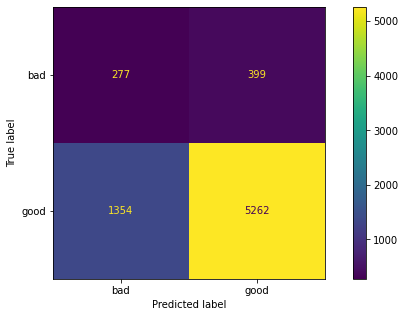

In [141]:
print(classification_report(preds,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(preds, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [142]:
def rf(xs, y, n_estimators=40, max_samples=20_000,
       max_features=0.5, min_samples_leaf=5,random_state=random_state):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=random_state).fit(xs, y)

In [143]:
rf_m = rf(xs, y)
preds_rf=rf_m.predict(valid_xs)

              precision    recall  f1-score   support

         bad       0.11      0.51      0.18       358
        good       0.97      0.79      0.87      6934

    accuracy                           0.78      7292
   macro avg       0.54      0.65      0.53      7292
weighted avg       0.93      0.78      0.84      7292



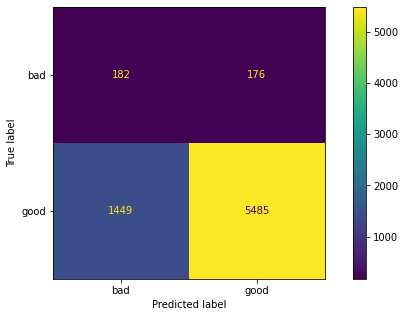

In [144]:
print(classification_report(preds_rf,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(preds_rf, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [339]:
from lightgbm import LGBMClassifier,plot_importance


In [146]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(xs,y)

LGBMClassifier(random_state=42)

              precision    recall  f1-score   support

         bad       0.03      0.72      0.06        67
        good       1.00      0.78      0.88      7225

    accuracy                           0.78      7292
   macro avg       0.51      0.75      0.47      7292
weighted avg       0.99      0.78      0.87      7292



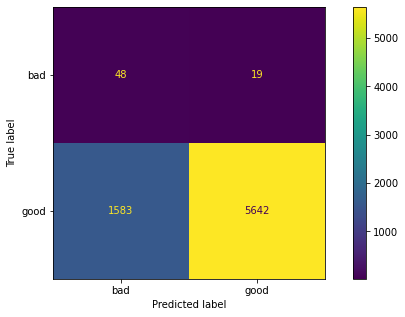

In [147]:
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(pred_boost,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(pred_boost, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

We need to maximise recall -> gradient boosted trees are the best

Feature importance

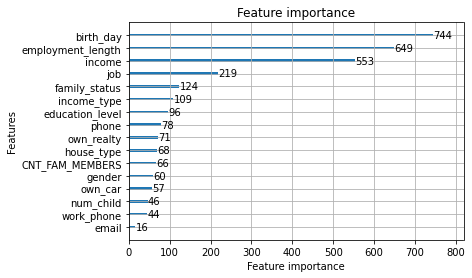

In [340]:
plot_importance(boosted_tree)

We can drop weak learners from looking at our boosted_tree feature importance.
We define a weak learner as less than 0.05 feature importance.

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [116]:
import imblearn

In [300]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [301]:
procs = [Categorify, Normalize]
cont,cat = cont_cat_split(train_df, max_card=1,dep_var=dep_var)
to = TabularPandas(train_df, procs, cat, cont,
                      splits=splits,y_names=dep_var)
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [303]:
xs["label"]=y
class_1=xs[y==1]
class_2=xs[y==2]
class_count_2, class_count_1 = y.value_counts()
print('class 2:', class_2.shape)
print('class 1:', class_1.shape)
class_2_under = class_2.sample(class_count_1)
test_under = pd.concat([class_2_under, class_1], axis=0)
y=test_under["label"]
xs=test_under.drop("label",axis=1)

class 2: (22550, 17)
class 1: (6615, 17)


              precision    recall  f1-score   support

         bad       0.56      0.27      0.37      3378
        good       0.56      0.81      0.67      3914

    accuracy                           0.56      7292
   macro avg       0.56      0.54      0.52      7292
weighted avg       0.56      0.56      0.53      7292



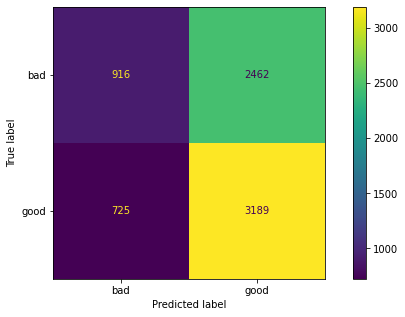

In [342]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(xs,y)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(pred_boost,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(pred_boost, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [343]:
from imblearn.under_sampling import TomekLinks

In [344]:
tl = TomekLinks()
X_res, y_res=tl.fit_resample(xs, y)

(13014, 16)

              precision    recall  f1-score   support

         bad       0.60      0.27      0.37      3677
        good       0.52      0.82      0.64      3615

    accuracy                           0.54      7292
   macro avg       0.56      0.54      0.50      7292
weighted avg       0.56      0.54      0.50      7292



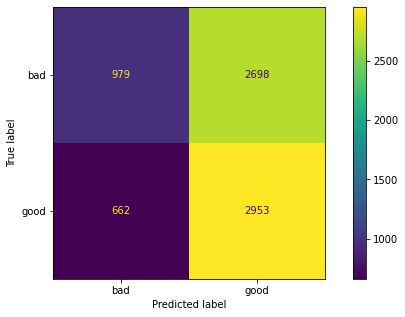

In [346]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(X_res,y_res)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(pred_boost,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(pred_boost, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [313]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(xs, y)
print(x_smote.shape)

(13230, 16)


              precision    recall  f1-score   support

         bad       0.56      0.27      0.37      3378
        good       0.56      0.81      0.67      3914

    accuracy                           0.56      7292
   macro avg       0.56      0.54      0.52      7292
weighted avg       0.56      0.56      0.53      7292



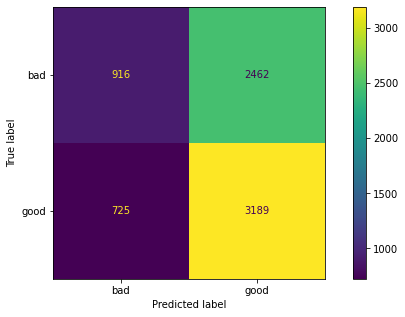

In [349]:
boosted_tree=LGBMClassifier(boosting_type="gbdt",random_state=random_state)
boosted_tree.fit(x_smote,y_smote)
pred_boost=boosted_tree.predict(valid_xs)
print(classification_report(pred_boost,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(pred_boost, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 

In [ ]:
from sklearn.svm import SVC

In [332]:
svc_model = SVC(class_weight='balanced', probability=True)
svc_model.fit(xs, y)

SVC(class_weight='balanced', probability=True)

              precision    recall  f1-score   support

         bad       0.61      0.23      0.33      4381
        good       0.40      0.78      0.53      2911

    accuracy                           0.45      7292
   macro avg       0.51      0.50      0.43      7292
weighted avg       0.53      0.45      0.41      7292



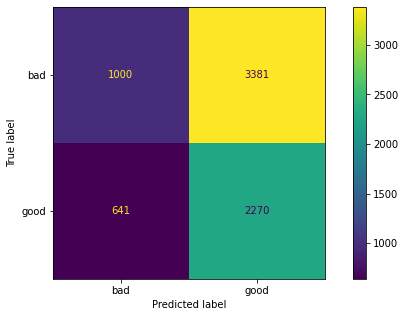

In [327]:
svc_predict = svc_model.predict(valid_xs)# check performance
print(classification_report(svc_predict,valid_y,target_names=int_to_labels_evm))
disp=ConfusionMatrixDisplay.from_predictions(svc_predict, valid_y,display_labels=int_to_labels_evm)
fig=disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(5) 